# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

ValueError: list.remove(x): x not in list

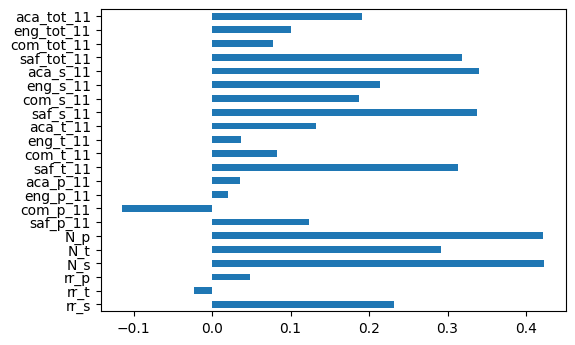

In [25]:
%matplotlib inline
correlations[survey_fields].plot.barh()

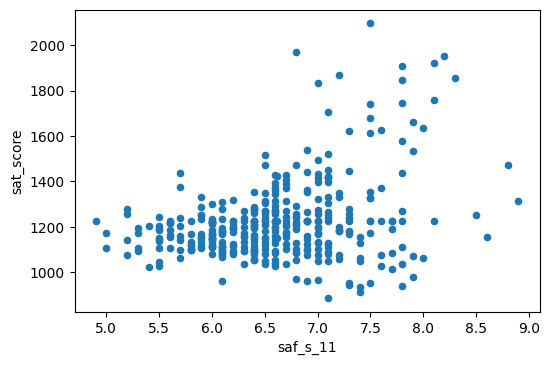

In [26]:
combined.plot.scatter("saf_s_11", "sat_score")

In [32]:
pd.options.display.max_seq_items = 200
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Demographic', 'School Name', 'Cohort', 'Total Cohort',
       'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
  

In [33]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
districts["saf_s_11"]

0     6.768611
1     6.910660
2     6.716667
3     6.885714
4     6.314286
5     6.950000
6     6.800000
7     6.364697
8     6.655000
9     6.577273
10    6.186667
11    7.116667
12    6.407692
13    6.685714
14    6.177778
15    5.875000
16    6.007143
17    6.190909
18    6.150000
19    7.120000
20    6.390909
21    7.025000
22    6.233333
23    7.107692
24    6.912500
25    6.760000
26    6.390000
27    6.627273
28    6.075000
29    7.033333
30    6.530000
31    6.766667
Name: saf_s_11, dtype: float64

In [34]:
districts.head(10)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


In [35]:
combined["boro"].head()

0    Manhattan
1    Manhattan
2    Manhattan
3    Manhattan
4    Manhattan
Name: boro, dtype: object

In [39]:
boroughs = combined.groupby("boro").agg(numpy.mean)
boroughs["saf_s_11"]

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

In [40]:
boroughs.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
boro,,,,,,,,,,,,,,,,,,,,,
Bronx,384.050714,393.891831,379.655657,1157.598203,96.473842,149.445409,135.694086,136.857093,9.548387,123.113090,...,12.0,12.0,10461.408602,549.569892,1.344086,0.0,0.0,0.0,40.845473,-73.890973
Brooklyn,391.336947,404.612644,385.414869,1181.364461,131.645682,202.857765,164.940094,183.870968,18.000000,168.902227,...,12.0,12.0,11216.150943,751.556604,1.971698,0.0,0.0,0.0,40.665555,-73.947829
Manhattan,421.070149,437.824710,419.436551,1278.331410,126.135363,192.661966,153.337778,155.421505,2.900000,143.512969,...,12.0,12.0,10024.744444,633.588889,1.433333,0.0,0.0,0.0,40.766244,-73.975350
Queens,422.274953,448.207556,416.270522,1286.753032,160.463942,238.014423,153.975000,307.208165,26.906250,254.299343,...,12.0,12.0,11343.000000,1187.187500,2.390625,0.0,0.0,0.0,40.715715,-73.836422
Staten Island,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.000000,380.528319,...,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726


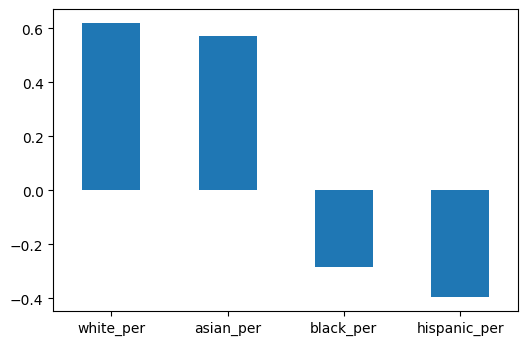

In [59]:
ethnicities = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[ethnicities].plot.bar(rot=0)

In [53]:
combined["hispanic_per"].value_counts()

99.8    5
57.2    5
70.4    4
64.3    3
64.5    3
       ..
25.8    1
57.9    1
38.1    1
11.9    1
42.0    1
Name: hispanic_per, Length: 272, dtype: int64

In [58]:
low_hisp = combined[(combined["hispanic_per"] > 25) & (combined["sat_score"] < 1000)]
low_hisp["school_name"]

91                  International Community High School
125                 Academy for Language and Technology
126                     Bronx International High School
139               Kingsbridge International High School
141               International School for Liberal Arts
176    Pan American International High School at Monroe
179                       High School of World Cultures
188                  Brooklyn International High School
225       International High School at Prospect Heights
253                           Multicultural High School
286              Pan American International High School
Name: school_name, dtype: object

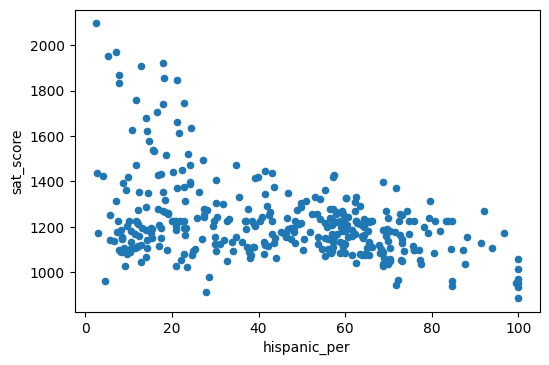

In [57]:
combined.plot.scatter("hispanic_per", "sat_score")

Text(0, 0.5, 'school name')

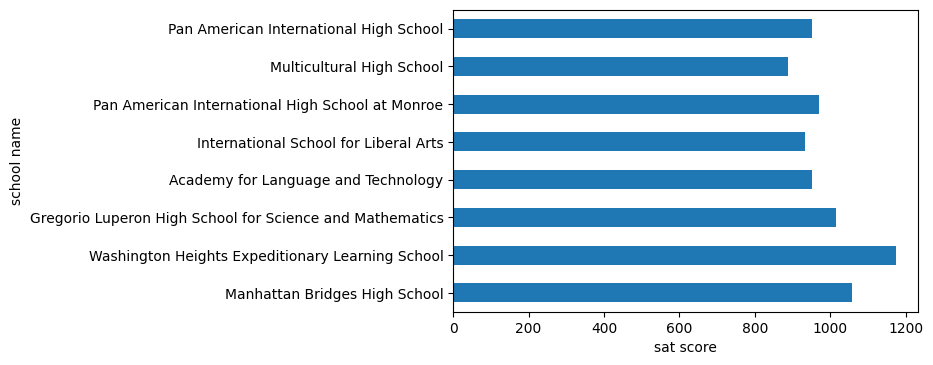

In [85]:
high_per_hisp = combined[combined["hispanic_per"] > 95]
ax = high_per_hisp.set_index("school_name").plot.barh(y="sat_score", legend=False)
ax.set_xlabel("sat score")
ax.set_ylabel("school name")

In [92]:
pd.set_option("max_colwidth", 300)
low_per_hisp = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
low_per_hisp["school_name"]

37                                  Stuyvesant High School
151                           Bronx High School of Science
187                         Brooklyn Technical High School
327    Queens High School for the Sciences at York College
356                    Staten Island Technical High School
Name: school_name, dtype: object

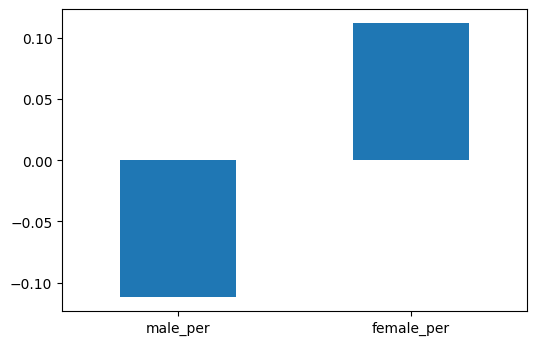

In [94]:
genders = ["male_per", "female_per"]
correlations[genders].plot.bar(rot=0)

In [97]:
high_fem = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
high_fem["school_name"]

5                                            Bard High School Early College
26                                            Eleanor Roosevelt High School
60                                                       Beacon High School
61     Fiorello H. LaGuardia High School of Music & Art and Performing Arts
302                                             Townsend Harris High School
Name: school_name, dtype: object

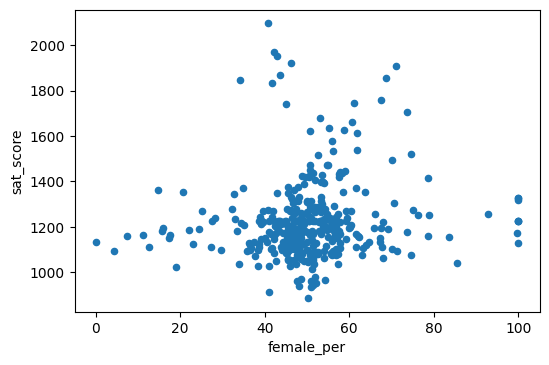

In [96]:
combined.plot.scatter("female_per", "sat_score")

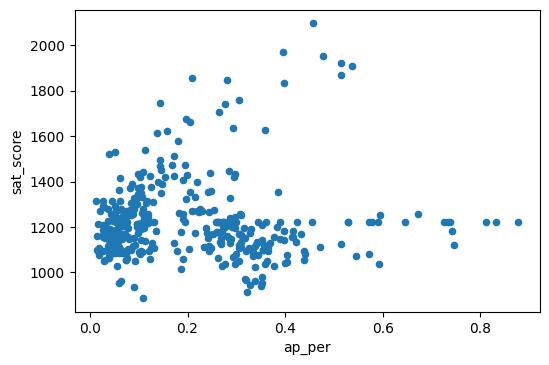

In [98]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")

- Determine whether there's a correlation between class size and SAT scores
- Figure out which neighborhoods have the best schools
- If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigate the differences between parent, teacher, and student responses to surveys.
- Assign scores to schools based on sat_score and other attributes.